In [1]:
import numpy as np
import random
import os 
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
import torch.nn.functional as F
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp import autocast

from torchsummary import summary
from sklearn.metrics import r2_score

from ray import tune

import json
import itertools
from itertools import groupby
import gzip 
from io import BytesIO
from time import time 

import matplotlib.pyplot as plt

# import pyBigWig
from scipy.sparse import csc_matrix
import math 

import torch.cuda.amp as amp

import functools

import captum 
from captum.attr import DeepLift, DeepLiftShap
# import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score

from copy import deepcopy

In [2]:
from modules import * 

To run a classification, we need to update the last block in the model (conv_block_5). Pytorch's cross entropy loss accepts logits as input, so we need the model's very last layer to be linear. 
I tried to update the conv_block_5 attribute using class inheritannce and attribute overriding, but it did not work for me. 

In [3]:
class upd_GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return torch.sigmoid(torch.Tensor([1.702]).cuda() * input) * input

def ones_(tensor: Tensor) -> Tensor:
    return torch.ones_like(tensor)

def zeros_(tensor: Tensor) -> Tensor:
    return torch.zeros_like(tensor)

class BasenjiModel_Classif(nn.Module):
    def __init__(self, num_targets, n_channel=4, max_len=128, 
                 conv1kc=64, conv1ks=15, conv1st=1, conv1pd=7, pool1ks=8, pool1st=1 , pdrop1=0.4, #conv_block_1 parameters
                 conv2kc=64, conv2ks=5, conv2st=1, conv2pd=3, pool2ks=4 , pool2st=1, pdrop2=0.4, #conv_block_2 parameters
                 conv3kc=round(64*1.125), conv3ks=5, conv3st=1, conv3pd=3, pool3ks=4 , pool3st=1, pdrop3=0.4, #conv_block_2 parameters
                 convdc = 6, convdkc=32 , convdks=3, debug=False):                 
        super(BasenjiModel_Classif, self).__init__()
        
        self.convdc = convdc
        self.debug = debug
        self.num_targets =  num_targets
        ## CNN + dilated CNN
        
        self.conv_block_1 = nn.Sequential(
            upd_GELU(),
            nn.Conv1d(n_channel, conv1kc, kernel_size=conv1ks, stride=conv1st, padding=conv1pd, bias=False),
            nn.BatchNorm1d(conv1kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool1ks),
            nn.Dropout(p=0.2))
                
        self.conv_block_2 = nn.Sequential(
            upd_GELU(),
            nn.Conv1d(conv1kc, conv2kc, kernel_size=conv2ks, stride=conv2st, padding=conv2pd, bias=False),
            nn.BatchNorm1d(conv2kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool2ks),
            nn.Dropout(p=0.2))
        
        self.conv_block_3 = nn.Sequential(
            upd_GELU(),
            nn.Conv1d(conv2kc, round(conv2kc*1.125), kernel_size=conv3ks, stride=conv3st, padding=conv3pd, bias=False),
            nn.BatchNorm1d(conv3kc, momentum=0.9, affine=True),
            nn.MaxPool1d(kernel_size=pool3ks),
            nn.Dropout(p=0.2))
        

        self.dilations = nn.ModuleList()
        for i in range(convdc):
            padding = 2**(i)
            self.dilations.append(nn.Sequential(
                upd_GELU(),
                nn.Conv1d(conv3kc, 32, kernel_size=3, padding=padding, dilation=2**i, bias=False),
                nn.BatchNorm1d(32, momentum=0.9, affine=True), 
                upd_GELU(),
                nn.Conv1d(32, 72, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm1d(72, momentum=0.9, affine=True), 
                nn.Dropout(p=0.25)))
            
        self.conv_block_4 = nn.Sequential(
            upd_GELU(),
            nn.Conv1d(72, 64, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64, momentum=0.9, affine=True), 
            nn.Dropout(p=0.1)) 
            
        self.conv_block_5 = nn.Sequential(
            upd_GELU(),
            nn.Linear(64, self.num_targets, bias=True)) 

    
        self.conv_block_1[1].weight.data = self.truncated_normal(self.conv_block_1[1].weight, 0.0, np.sqrt(2/60)) #4
        self.conv_block_2[1].weight.data = self.truncated_normal(self.conv_block_2[1].weight, 0.0, np.sqrt(2/322)) # conv1kc
        self.conv_block_3[1].weight.data = self.truncated_normal(self.conv_block_3[1].weight, 0.0, np.sqrt(2/322)) # conv1kc
        self.conv_block_4[1].weight.data = self.truncated_normal(self.conv_block_4[1].weight, 0.0, np.sqrt(2/72)) # 72
        self.conv_block_5[1].weight.data = self.truncated_normal(self.conv_block_5[1].weight, 0.0, np.sqrt(2/64)) # 64        
        self.conv_block_1[2].weight.data = ones_(self.conv_block_1[2].weight)
        self.conv_block_2[2].weight.data = ones_(self.conv_block_2[2].weight)
        self.conv_block_3[2].weight.data = ones_(self.conv_block_3[2].weight)
        self.conv_block_4[2].weight.data = ones_(self.conv_block_4[2].weight)

        
        for i in range(convdc):
            self.dilations[i][1].weight.data = self.truncated_normal(self.dilations[i][1].weight, 0.0, np.sqrt(2/218)) # 72
            self.dilations[i][-2].weight.data = self.truncated_normal(self.dilations[i][-2].weight, 0.0, np.sqrt(2/32)) # 32
            self.dilations[i][2].weight.data = zeros_(self.dilations[i][2].weight)
            self.dilations[i][-2].weight.data = ones_(self.dilations[i][-2].weight)

    
    def truncated_normal(self, t, mean, std):
        torch.nn.init.normal_(t, mean, std)
        while True:
            cond = torch.logical_or(t < (mean - 2.28*std), t > (mean + 2.28*std))
            if not torch.sum(cond):
                break
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
        return t


    def forward(self, seq):
        if self.debug: 
            print (seq.shape)
        seq = self.conv_block_1(seq)
        if self.debug: 
            print ('conv1', seq.shape)
        seq = self.conv_block_2(seq)
        if self.debug: 
            print ('conv2', seq.shape)
        seq = self.conv_block_3(seq)
        if self.debug: 
            print ('conv3', seq.shape)
        for i in range(self.convdc):
            if i == 0:
                y = self.dilations[i](seq)
            if i >= 1:
                y = y.add(self.dilations[i](seq))
            if self.debug: 
                print ('dil', i, self.dilations[i](seq).shape)
        if self.debug:
            print ('y', y.shape)
        res = self.conv_block_4(y)
        if self.debug: 
            print ('res', res.shape)
        res_lin = res.transpose(1, 2)
        if self.debug: 
            print ('res_lin', res_lin.shape)
        res = self.conv_block_5(res_lin)
        if self.debug: 
            print ('res', res.shape)
        return res
        
    def compile(self, device='cpu'):
        self.to(device)

First step for the analysis is to initialize and load the model, trainer and get the data. 

In [4]:
param_vals = { 
"optimizer" : "Adam", 
"init_lr": 0.001, 
"optimizer_momentum": 0.9, 
"weight_decay": 1e-3, 
"loss": "bce", 
"num_targets": 1,
"seq_len": 128*128*8,
"target_window": 1024*32,
"batch_size": 1,
"cut": 0.8,
"num_workers": 0,
"num_epochs": 1,
}

In [5]:
memmap_data_contigs_dir = '/data/users/goodarzilab/darya/work/basenji_pytorch/hg38_memmaps'
targets_memmap_data_dir_cl = '/data/users/goodarzilab/darya/work/basenji_pytorch/hg38_targets_memmaps_CL.ATAC'
targets_memmap_data_dir_pdx = '/data/users/goodarzilab/darya/work/basenji_pytorch/hg38_targets_memmaps_PDX.ATAC'

In [6]:
model = BasenjiModel_Classif(num_targets=1)
model.compile('cuda')

In [7]:
trainer = Trainer(param_vals, model, memmap_data_contigs_dir, targets_memmap_data_dir_cl, targets_memmap_data_dir_pdx, mode='classification')

init dsets


In [8]:
trainer.load_model(trainer.model, "basenji_toy_upd_motif_32k_recfield_13epochs.pt")

In [9]:
train_loader, val_loader = trainer.make_loaders(augm=False)

In [10]:
batch = next(iter(train_loader))
X, y = trainer.get_input(batch)

Then, for the baseline data, we shuffle out inputs. Since the trainer outputs one-hot incoded data, we reverse that step, randomly permute the values and one-hot encode them again. 

In [11]:
X_ints = torch.argmax(X, dim=1).squeeze()#.cpu()

In [12]:
idx = torch.randperm(X_ints.shape[-1])

In [13]:
# X_shuffled = torch.stack([X_ints[i][idx] for i in range(X_ints.shape[0])])
# X_shuffled = torch.transpose(F.one_hot(X_shuffled), 2, 1)#.unsqueeze(0)

X_shuffled = X_ints[idx]
X_shuffled = torch.transpose(F.one_hot(X_shuffled), 1, 0).unsqueeze(0)
# X_shuffled = F.one_hot(X_shuffled).unsqueeze(0)

Next, we use the DeepLift algorithm from the Captum package.

In [15]:
dl = DeepLift(trainer.model)
attribution = dl.attribute(X, baselines=X_shuffled.float(), target=1)

/data/users/goodarzilab/darya/anaconda3/envs/basenji_pytorch/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/data/users/goodarzilab/darya/anaconda3/envs/basenji_pytorch/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:320: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/data/users/goodarzilab/darya/anaconda3/envs/basenji_pytorch/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:452: UserWarning: An invalid module MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  warnings.warn(
/data/users/goodarzilab/darya

In [16]:
nucs = np.arange(4)
inp_vals = X.cpu().detach().numpy()
attr = attribution.cpu().detach().numpy()

Then, for each minibatch, we collect the attribute values. They are grouped for each nucleotide, so it's the same thing as reversing one-hot encoding. 

In [17]:
nucs_vals = np.zeros((inp_vals.shape[0], inp_vals.shape[-1]))
attr_vals = np.zeros((inp_vals.shape[0], inp_vals.shape[-1]))


for j in range(inp_vals.shape[0]):
    for i in range(len(nucs)):
        ids = np.where(inp_vals[j][i] == 1.)
        nucs_vals[j][ids] = nucs[i]
        for idx in ids: 
            attr_vals[j][idx] = attr[j][i][idx]

Finally, we need to cross-reference the deeplift values with the actual locations of the motifs. 

In [18]:
import re
motif_str = '202131'

def return_ids(test_str, motif_str):
    ind_found = np.hstack([[m.start() + i] for m in re.finditer(motif_str, test_str) for i in range(len(motif_str))])
    return ind_found

def get_motif_loc(seq):
    seq_subset_str = "".join([str(int(s)) for s in seq])
    test_empty = np.zeros(len(seq_subset_str))
    ids = return_ids(seq_subset_str, motif_str)
    test_empty[ids] = 1
    return ids, test_empty

def get_true_targets(labels_again):
    ids, test_empty = get_motif_loc(labels_again)
    rand_ids = ids[0::6]
    diff_ids = np.diff(rand_ids)
    bins = np.arange(0, labels_again.shape[0], 128)
    # bin_indices = np.digitize(rand_ids[np.where(diff_ids >= 180)[0]], bins) #rand_ids[diff_ids_range], bins)
    bin_indices = np.digitize(rand_ids[np.where(diff_ids >= 180)], bins) #rand_ids[diff_ids_range], bins)
    targets = torch.zeros(len(bins))
    targets[bin_indices] = 1
    return targets, rand_ids[np.where(diff_ids >= 160)]

In [20]:
targets = get_true_targets(X_ints)[-1]

In [22]:
targets_empty = torch.zeros(X_ints.shape)
targets_empty[targets] = 1.

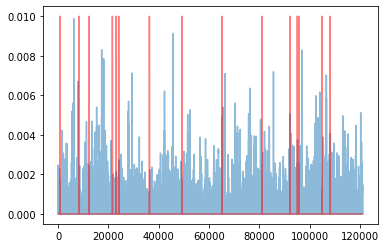

In [26]:
plt.plot(np.arange(len(attr_vals[0])-10000), np.abs(attr_vals[0][10000:]), alpha=0.5)
plt.plot(np.arange(len(attr_vals[0])-10000), targets_empty[10000:]/(10**2), alpha=0.5, color='r')
plt.show()